#### Goal: Implementing a fraud detection algorithm based on user text
*  Author: Israel Ilori

In [10]:
#import required packages
import nltk
import string
import warnings
import collections
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()

""" 
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

"""
nltk.download('punkt')
nltk.download('stopwords')
from langdetect import detect
import matplotlib.pyplot as plt
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

from numpy import std
from numpy import mean
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oluwatomiwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oluwatomiwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# check if data column in one dataset contains values for column in another dataset
#data_pii.address.isin(new_data_pii.address).sum()

In [13]:
#read in the data
#define the column names and map to the data header
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', header=None, names=cols, encoding="latin-1")

In [14]:
#view top 5 rows
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
#check the shape of the data
df.shape

(1600000, 6)

In [16]:
#if there was enough time, an option would have been to apply the language detection funtion to detect the language of each tweet
#then save to a new column
#df['lang'] = df['text'].progress_apply(detect)

In [17]:
#check for missing values
df.isnull().sum()

sentiment       0
id              0
date            0
query_string    0
user            0
text            0
dtype: int64

In [18]:
#check for duplicates and drop if found
df = df.drop_duplicates(subset=['text'])
df.shape

(1581466, 6)

In [19]:
#check the distribution of the target class
df['sentiment'].value_counts()

4    791281
0    790185
Name: sentiment, dtype: int64

<AxesSubplot: ylabel='count'>

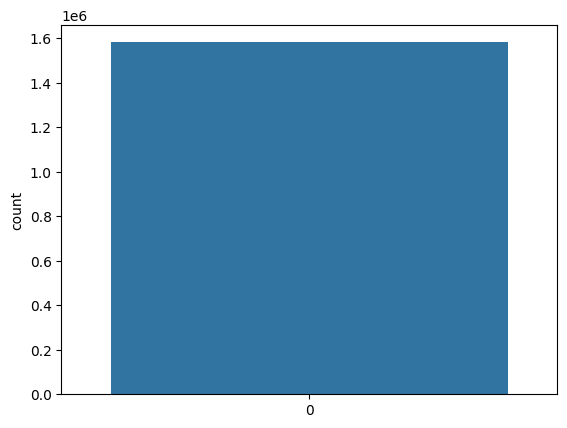

In [20]:
#check the distribution of the target class
#output to a view
df['sentiment'].value_counts()
sns.countplot(df['sentiment'])

In [21]:
#I'm guessing 0 is the negative class and 4 is the positive class
#any reason why the positive class is 4? if not re-map to 1
df['sentiment'] = df['sentiment'].map({0:0, 4:1})

<AxesSubplot: ylabel='count'>

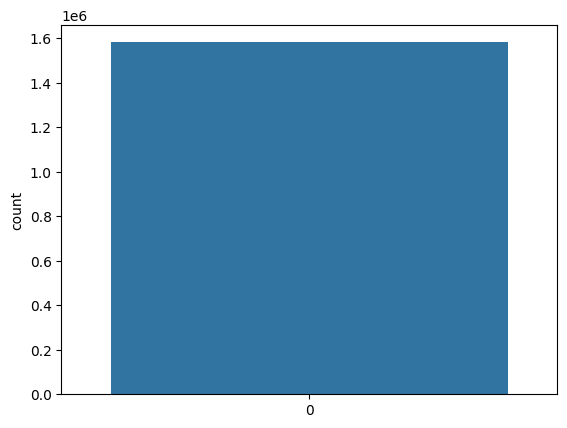

In [22]:
#validate the change
sns.countplot(df['sentiment'])

In [23]:
# clean the data
remove_punctuation = str.maketrans('', '', string.punctuation)
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['n', 't', "'", 'im'])

def clean_text(text):
    uncased = text.translate(remove_punctuation).lower()
    tokens = [token for token in nltk.word_tokenize(uncased) 
                if len(token) > 1
                and not token in stop_words
                and not (token.isnumeric() and len(token) != 4)
                and (not token.isnumeric() or token.isalpha())]
    return " ".join(tokens)

In [24]:
df['cleaned_text'] = df['text'].progress_apply(clean_text)

100%|██████████| 1581466/1581466 [02:21<00:00, 11186.99it/s]


In [25]:
#remove duplicates
df = df.drop_duplicates(subset=['cleaned_text'])
df.shape

(1551659, 7)

Perform Word Cloud to get a glimpse of the data.

We want to build a word cloud for all the class labels in question.

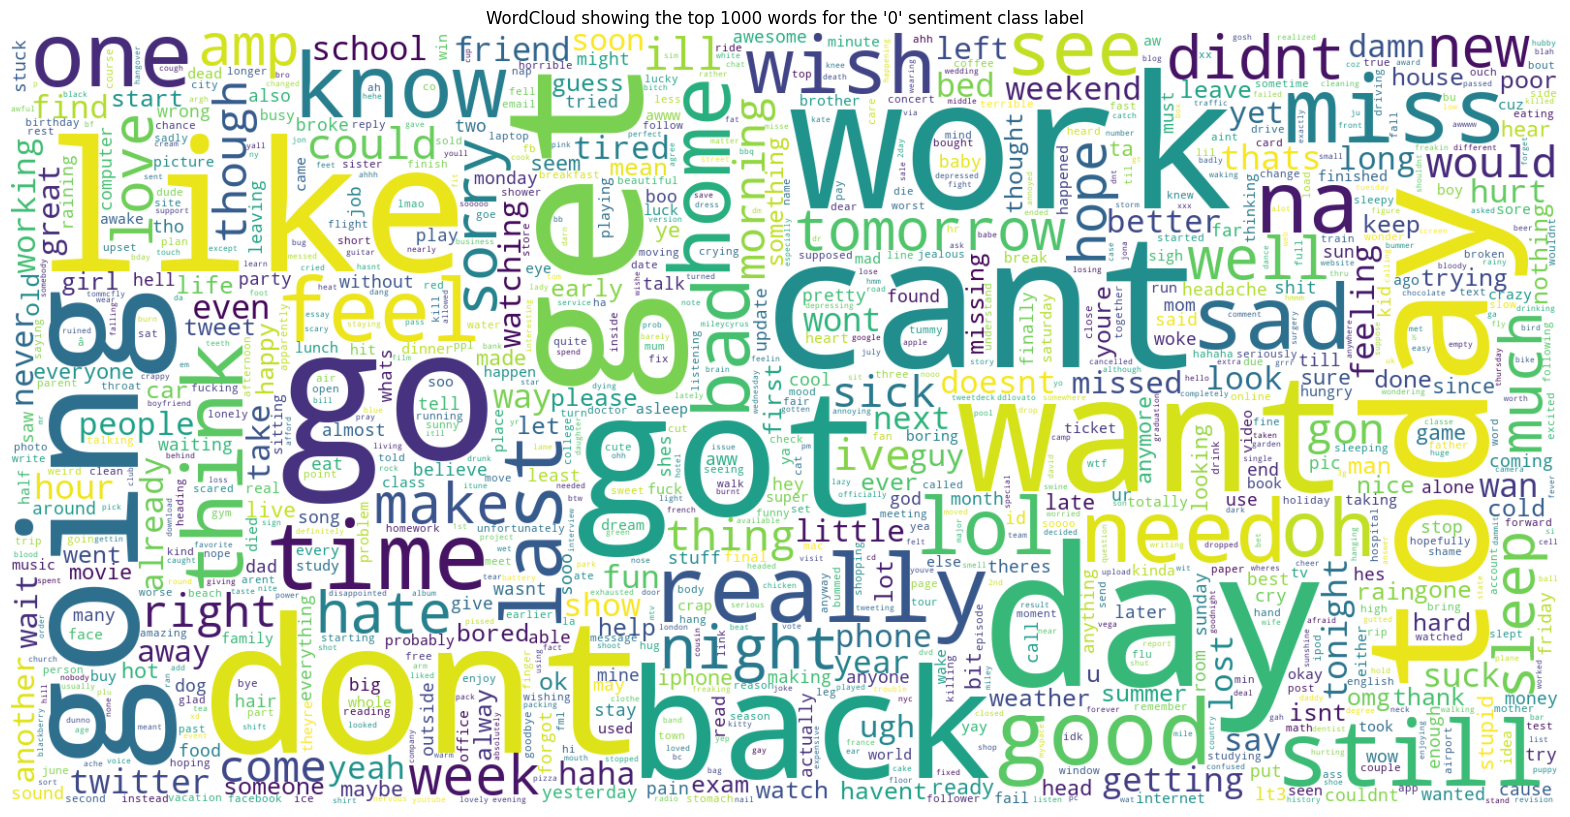

In [26]:
# get the class label for the '0' sentiment class
class_0 = df[df['sentiment'] == 0]

# convert to series
class_0_strings = pd.Series(class_0['cleaned_text']).str.cat(sep=' ')

# plot wordcloud
class_0_wordcloud = WordCloud(width=1600, stopwords=stop_words, height=800,
                        max_font_size=200, max_words=1000, collocations=False,
                        background_color='white').generate(class_0_strings)

plt.figure(figsize=(20,20))
plt.imshow(class_0_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud showing the top 1000 words for the '0' sentiment class label")
plt.show()

In [27]:
class_0_words = [word for word in " ".join(df['cleaned_text']).split() if word not in set(stop_words)]

counted_words_class_0 = collections.Counter(class_0_words)
word_count_class_0 = {}

for letter, count in counted_words_class_0.most_common(30):
    word_count_class_0[letter] = count
 
for i,j in word_count_class_0.items():
    print('Word: {0}, Count: {1}'.format(i,j))

Word: good, Count: 86645
Word: get, Count: 80810
Word: day, Count: 79733
Word: like, Count: 77163
Word: go, Count: 71374
Word: got, Count: 68659
Word: dont, Count: 65677
Word: today, Count: 63207
Word: going, Count: 62697
Word: love, Count: 62558
Word: cant, Count: 61301
Word: work, Count: 59613
Word: time, Count: 55295
Word: lol, Count: 54916
Word: back, Count: 54550
Word: one, Count: 51719
Word: know, Count: 50787
Word: really, Count: 48725
Word: see, Count: 45345
Word: well, Count: 43757
Word: still, Count: 42191
Word: new, Count: 41335
Word: na, Count: 41001
Word: want, Count: 40853
Word: think, Count: 40654
Word: night, Count: 40398
Word: amp, Count: 40165
Word: thanks, Count: 39139
Word: home, Count: 37839
Word: oh, Count: 37741


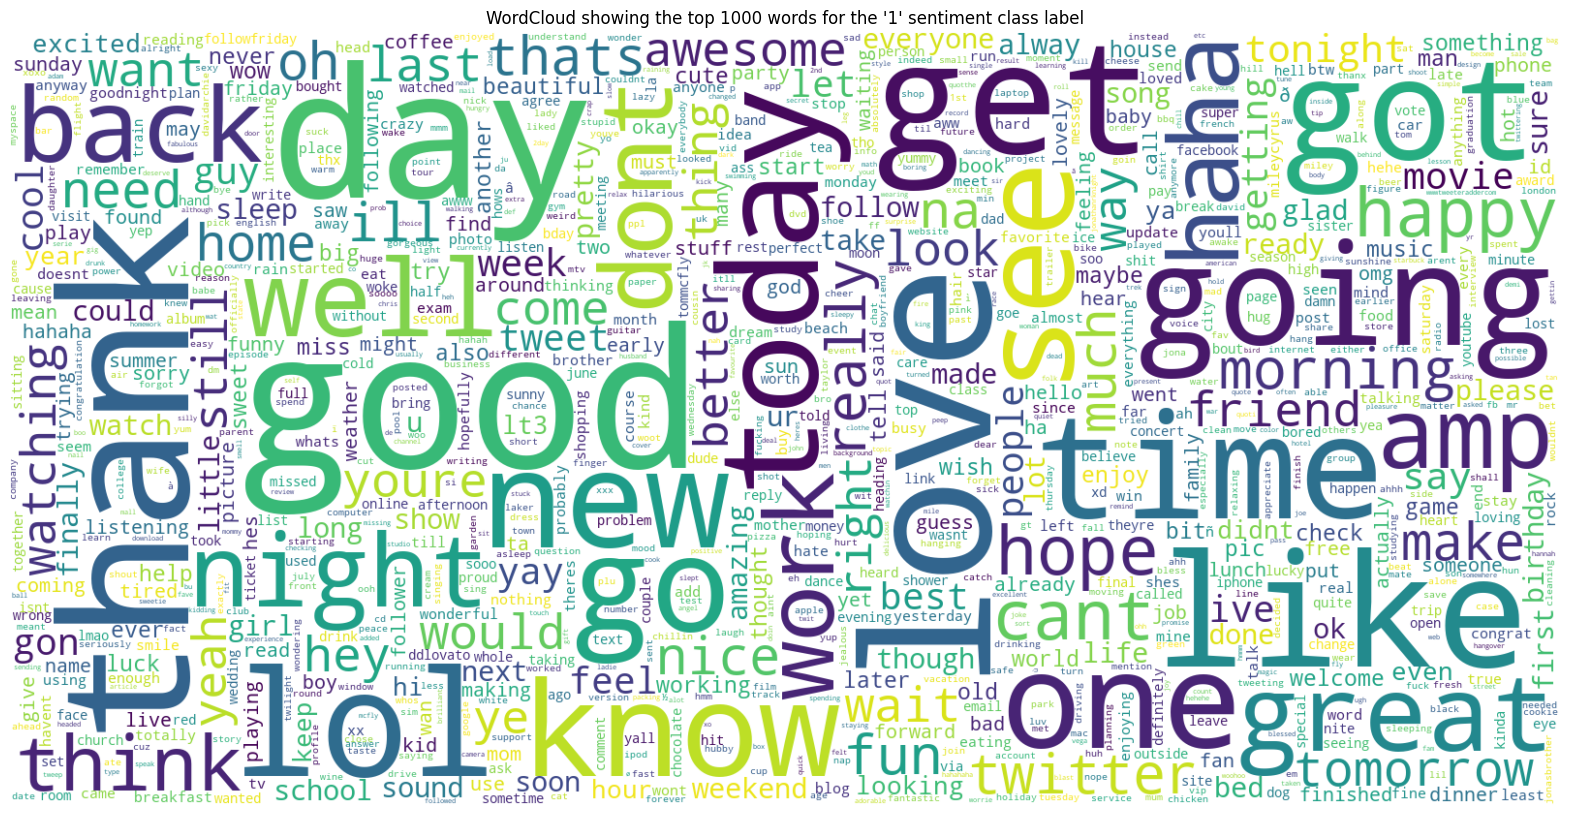

In [28]:
# get the class label for the '1' sentiment class
class_1 = df[df['sentiment'] == 1]

# convert to series
class_1_strings = pd.Series(class_1['cleaned_text']).str.cat(sep=' ')

# plot wordcloud
class_1_wordcloud = WordCloud(width=1600, stopwords=stop_words, height=800,
                        max_font_size=200, max_words=1000, collocations=False,
                        background_color='white').generate(class_1_strings)

plt.figure(figsize=(20,20))
plt.imshow(class_1_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud showing the top 1000 words for the '1' sentiment class label")
plt.show()

In [29]:
class_1_words = [word for word in " ".join(df['cleaned_text']).split() if word not in set(stop_words)]

counted_words_class_1 = collections.Counter(class_1_words)
word_count_class_1 = {}

for letter, count in counted_words_class_1.most_common(30):
    word_count_class_1[letter] = count
 
for i,j in word_count_class_1.items():
    print('Word: {0}, Count: {1}'.format(i,j))

Word: good, Count: 86645
Word: get, Count: 80810
Word: day, Count: 79733
Word: like, Count: 77163
Word: go, Count: 71374
Word: got, Count: 68659
Word: dont, Count: 65677
Word: today, Count: 63207
Word: going, Count: 62697
Word: love, Count: 62558
Word: cant, Count: 61301
Word: work, Count: 59613
Word: time, Count: 55295
Word: lol, Count: 54916
Word: back, Count: 54550
Word: one, Count: 51719
Word: know, Count: 50787
Word: really, Count: 48725
Word: see, Count: 45345
Word: well, Count: 43757
Word: still, Count: 42191
Word: new, Count: 41335
Word: na, Count: 41001
Word: want, Count: 40853
Word: think, Count: 40654
Word: night, Count: 40398
Word: amp, Count: 40165
Word: thanks, Count: 39139
Word: home, Count: 37839
Word: oh, Count: 37741


Perform Traditional ML to serve as a Baseline Model for Comaprison

In [30]:
# performing the multiclass classification

X = df['cleaned_text']
y = df['sentiment']

# split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42, stratify=df['sentiment'])

# encode the data
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)

tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(df['cleaned_text'])

X_train_vectorized = tfidf_vect.transform(X_train)
X_valid_vectorized = tfidf_vect.transform(X_valid)

model_linear = LogisticRegression(solver='saga').fit(X_train_vectorized, y_train)

In [31]:
# make predictions on the validation set
y_pred = model_linear.predict(X_valid_vectorized)
accuracy = accuracy_score(y_pred, y_valid)

skf5 = StratifiedKFold(n_splits=5)

scores = cross_val_score(model_linear, X_train_vectorized, y_train, scoring='accuracy', cv=skf5, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.772 (0.001)


              precision    recall  f1-score   support

           0       0.78      0.75      0.77    254967
           1       0.76      0.80      0.78    257081

    accuracy                           0.77    512048
   macro avg       0.77      0.77      0.77    512048
weighted avg       0.77      0.77      0.77    512048

AxesSubplot(0.125,0.11;0.62x0.77)


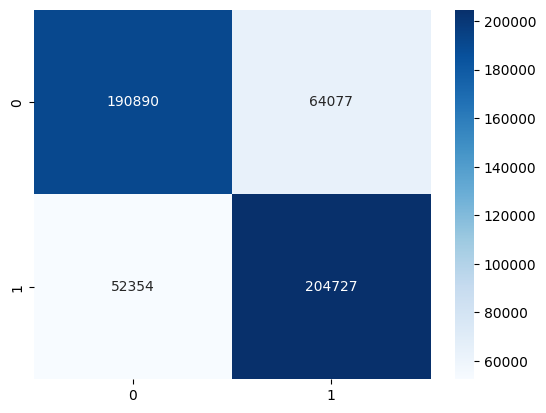

In [32]:
# classification report
print (classification_report(y_valid, y_pred))

target_class = ['0', '1']
confusion_report = confusion_matrix(y_valid, y_pred, labels=[0, 1])
df_cfm = pd.DataFrame(confusion_report, index = target_class, columns = target_class)
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
print(cfm_plot)

In [33]:
#implement a RandomForest model to serve as a comparison

In [34]:
# using Random Forest
model_RF = RandomForestClassifier(random_state = 42).fit(X_train_vectorized, y_train)

# make predictions on the validation set
y_pred = model_RF.predict(X_valid_vectorized)
accuracy = accuracy_score(y_pred, y_valid)

skf5 = StratifiedKFold(n_splits=5)

scores = cross_val_score(model_RF, X_train_vectorized, y_train, scoring='accuracy', cv=skf5, n_jobs=-1)

In [ ]:
#this was taking a ton of time to run and as such I proceeded to submitting without the results.

In [ ]:
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))